<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week13/SOM_countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to SOM

In [2]:
# Re-import necessary libraries after code execution state reset
!pip install minisom --quiet

  Preparing metadata (setup.py) ... done


## Data: European Countries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Data: [Area, Population]
country_data = np.array([
    [82519, 9104772],
    [30452, 11754004],
    [110001, 6447710],
    [55896, 3850894],
    [9213, 920701],
    [77212, 10827529],
    [41987, 5932654],
    [43110, 1365884],
    [304316, 5563970],
    [633886, 68070697],
    [353296, 84358845],
    [130048, 10394055],
    [91248, 9597085],
    [68655, 5194336],
    [297825, 58850717],
    [63290, 1883008],
    [62643, 2857279],
    [2586, 660809],
    [313, 542051],
    [34188, 17811291],
    [307236, 36753736],
    [90996, 10467366],
    [234270, 19051562],
    [48702, 5428792],
    [20145, 2116792],
    [502654, 48059777],
    [407300, 10521556]
])

# Data: [Area, Population, GDP per capita 2023]
country_data = np.array([
    [82519, 9104772, 56506],     # Austria
    [30452, 11754004, 53475],    # Belgium
    [110001, 6447710, 15798],    # Bulgaria
    [55896, 3850894, 21460],     # Croatia
    [9213, 920701, 34701],       # Cyprus
    [77212, 10827529, 30427],    # Czechia
    [41987, 5932654, 61296],     # Denmark
    [43110, 1365884, 29824],     # Estonia
    [304316, 5563970, 53756],    # Finland
    [633886, 68070697, 44461],   # France
    [353296, 84358845, 52746],   # Germany
    [130048, 10394055, 38373],   # Greece
    [91248, 9597085, 22147],     # Hungary
    [68655, 5194336, 103685],    # Ireland
    [297825, 58850717, 38373],   # Italy
    [63290, 1883008, 24000],     # Latvia
    [62643, 2857279, 27000],     # Lithuania
    [2586, 660809, 128259],      # Luxembourg
    [313, 542051, 34000],        # Malta
    [34188, 17811291, 62536],    # Netherlands
    [307236, 36753736, 22131],   # Poland
    [90996, 10467366, 29000],    # Portugal
    [234270, 19051562, 21420],   # Romania
    [48702, 5428792, 23000],     # Slovakia
    [20145, 2116792, 32000],     # Slovenia
    [502654, 48059777, 44461],   # Spain
    [407300, 10521556, 58100]    # Sweden
])

country_names = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
                 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
                 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
                 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

labels = ['Area (normalized)', 'Population (normalized)', 'GDP per capita 2023 (normalized)']

print(f'Data shape: {country_data.shape}')

# Normalize the data (similar to mapminmax in MATLAB)
scaler = MinMaxScaler()
#scaler = StandardScaler()
data_scaled = scaler.fit_transform(country_data)


# --- Scatter plot of normalized data ---
def plot_data(index_0, index_1, data_scaled, labels, country_names):
  plt.figure(figsize=(8, 6))
  plt.scatter(data_scaled[:,index_0], data_scaled[:,index_1])
  for i, name in enumerate(country_names):
      plt.text(data_scaled[i,index_0]+0.01, data_scaled[i,index_1], name, fontsize=6)
  plt.title(f"Countries: {labels[index_0]} vs {labels[index_1]}")
  #plt.xscale('log')  # logarithmic scale (area)
  #plt.yscale('log')  # logarithmic scale (population)
  plt.xlabel(labels[index_0])
  plt.ylabel(labels[index_1])
  plt.grid(True)
  plt.show()



Data shape: (27, 3)


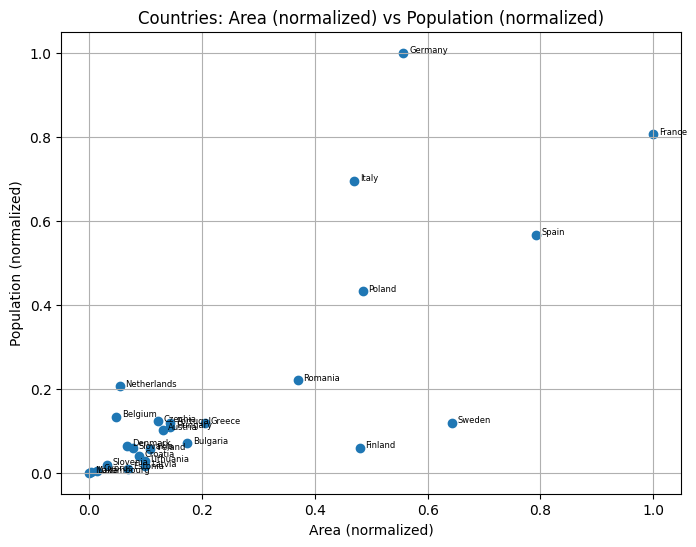

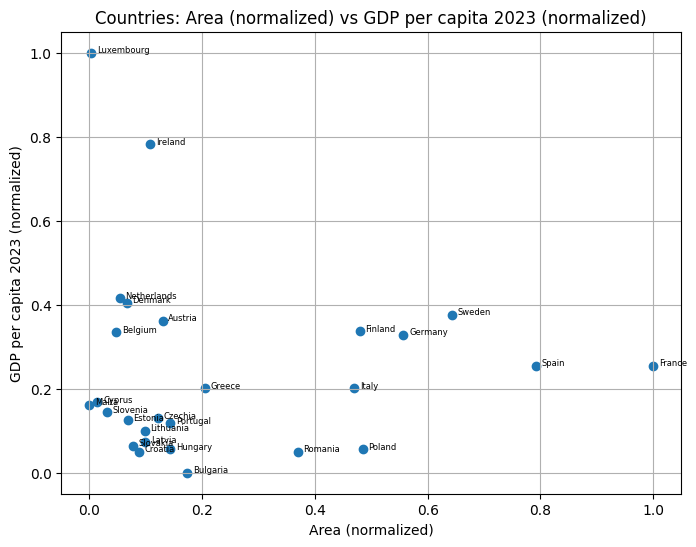

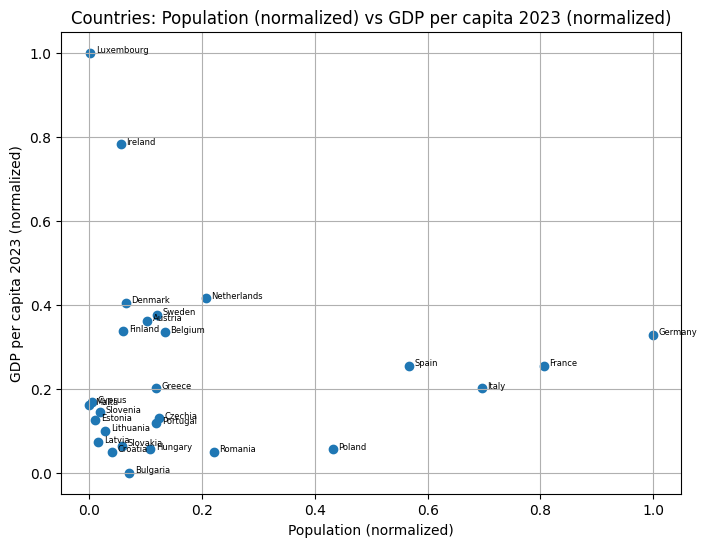

In [16]:
# --- Scatter plot of normalized data ---
plot_data(0, 1, data_scaled, labels, country_names)
plot_data(0, 2, data_scaled, labels, country_names)
plot_data(1, 2, data_scaled, labels, country_names)


## Train SOM:

In [114]:
from minisom import MiniSom
from collections import defaultdict

# Initialize and train SOM
som_shape = (6, 6)

# parameters:
learning_rate = 0.5

som = MiniSom(
    x=som_shape[0],         # number of neurons along the x-axis (width of the SOM grid)
    y=som_shape[1],         # number of neurons along the y-axis (height of the SOM grid)
    input_len=3,            # dimensionality of the input data (number of features)
    sigma=1.0,              # spread of the neighborhood function (controls how far the influence of the BMU reaches)
    learning_rate=0.5,      # initial learning rate (decreases over time)
    neighborhood_function='gaussian',  # function for neighborhood influence ('gaussian', 'mexican_hat', 'bubble', 'triangle')
    activation_distance='euclidean',   # distance metric for BMU search ('euclidean', 'cosine', etc.)
    topology='rectangular',  # topology of the map grid ('rectangular' or 'hexagonal')
    random_seed=42          # random seed for reproducibility (optional)
)
som.random_weights_init(data_scaled)
som.train_random(data_scaled, 1000)

# Create a dictionary to store which countries fall into each SOM neuron (BMU)
bmu_positions = defaultdict(list)
for i, x in enumerate(data_scaled):
    bmu = som.winner(x)  # Best Matching Unit for each country
    bmu_positions[bmu].append(country_names[i])  # Group countries by BMU position



## Visualizations:
### Weight planes:

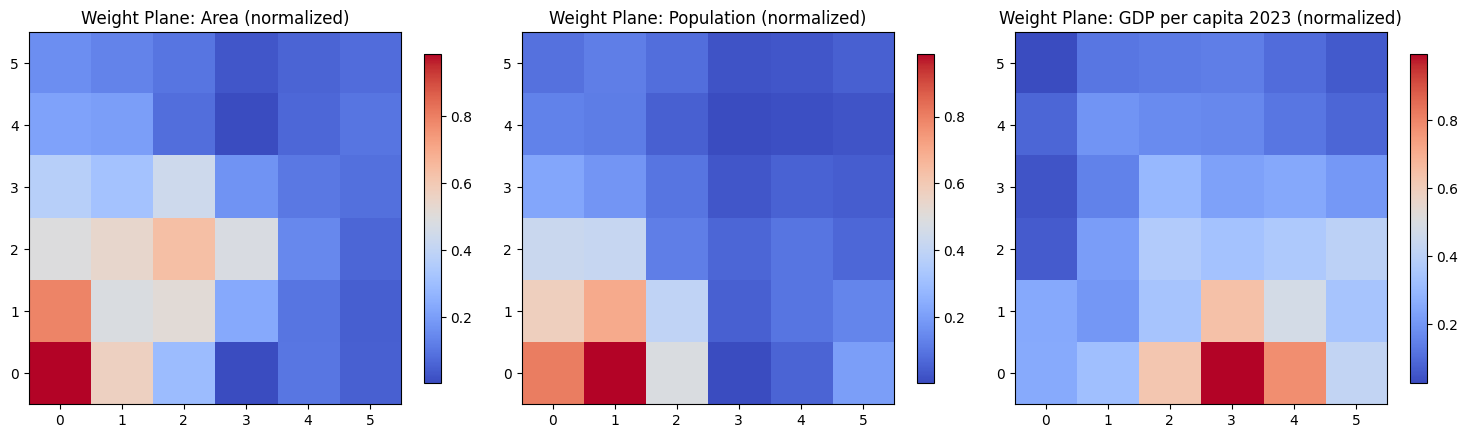

In [115]:
import matplotlib.pyplot as plt

def plot_weight_planes(som, feature_names):
    """
    Plot one weight plane per input feature.
    """
    weights = som.get_weights()  # shape: (x, y, features)
    n_features = weights.shape[2]
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

    if n_features == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        im = ax.imshow(weights[:, :, i].T, cmap='coolwarm', origin='lower')
        ax.set_title(f'Weight Plane: {feature_names[i]}')
        fig.colorbar(im, ax=ax, shrink=0.7)

    plt.tight_layout()
    plt.show()

plot_weight_planes(som, labels)

### U-matrix (Unified Distance Matrix)

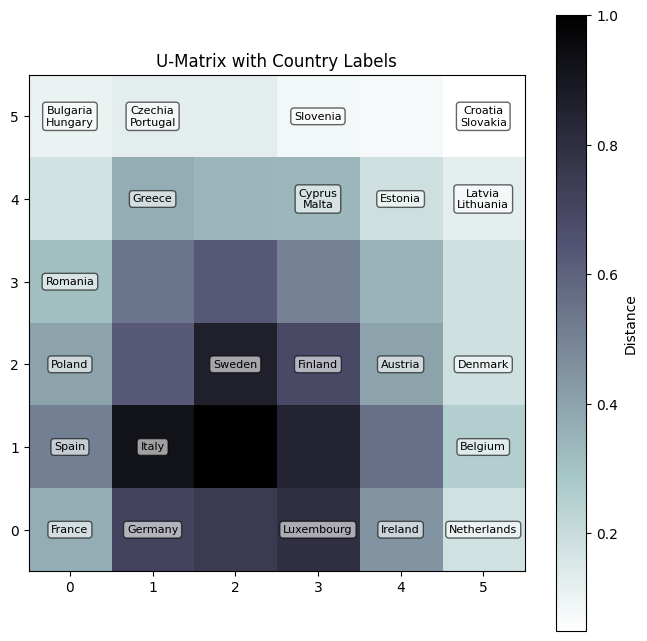

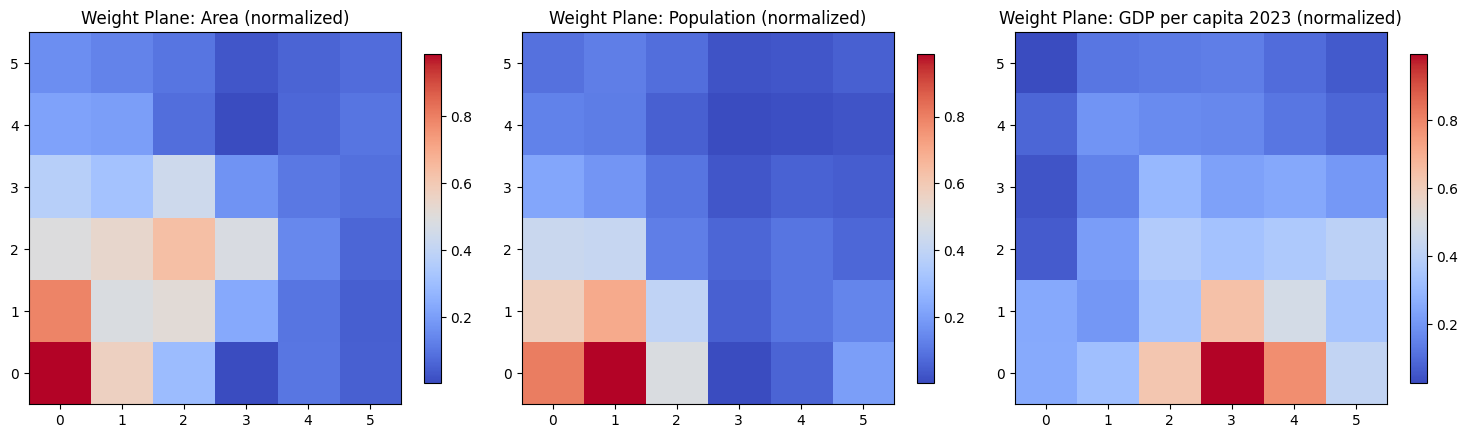

In [116]:
def plot_U_matrix(som, bmu_positions):
    # Plot the U-matrix (Unified Distance Matrix
    umat = som.distance_map().T  # transpose for correct orientation
    plt.figure(figsize=(8, 8))
    plt.imshow(umat, cmap='bone_r', origin='lower')  # U-matrix as heatmap
    plt.colorbar(label='Distance') # Color scale showing distance between neighboring neurons

    # Plot country names at their BMU positions
    for (x, y), names in bmu_positions.items():
        label = "\n".join(names)
        plt.text(x, y, label, ha='center', va='center', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

    plt.title("U-Matrix with Country Labels")
    plt.grid(False)
    plt.show()
plot_U_matrix(som, bmu_positions)
plot_weight_planes(som, labels)


In [117]:
# Get winner coordinates for each country
bmu_coords = np.array([som.winner(x) for x in data_scaled])

# Convert coordinates to 1D cluster IDs
cluster_ids = [int(x * som_shape[1] + y) for x, y in bmu_coords]

# Group countries by cluster
from collections import defaultdict
clusters = defaultdict(list)
for i, cid in enumerate(cluster_ids):
    clusters[cid].append(country_names[i])

# Print grouped countries
for cid, countries in sorted(clusters.items()):
    print(f"Representant {cid}: {countries}")


Representant 0: ['France']
Representant 1: ['Spain']
Representant 2: ['Poland']
Representant 3: ['Romania']
Representant 5: ['Bulgaria', 'Hungary']
Representant 6: ['Germany']
Representant 7: ['Italy']
Representant 10: ['Greece']
Representant 11: ['Czechia', 'Portugal']
Representant 14: ['Sweden']
Representant 18: ['Luxembourg']
Representant 20: ['Finland']
Representant 22: ['Cyprus', 'Malta']
Representant 23: ['Slovenia']
Representant 24: ['Ireland']
Representant 26: ['Austria']
Representant 28: ['Estonia']
Representant 30: ['Netherlands']
Representant 31: ['Belgium']
Representant 32: ['Denmark']
Representant 34: ['Latvia', 'Lithuania']
Representant 35: ['Croatia', 'Slovakia']


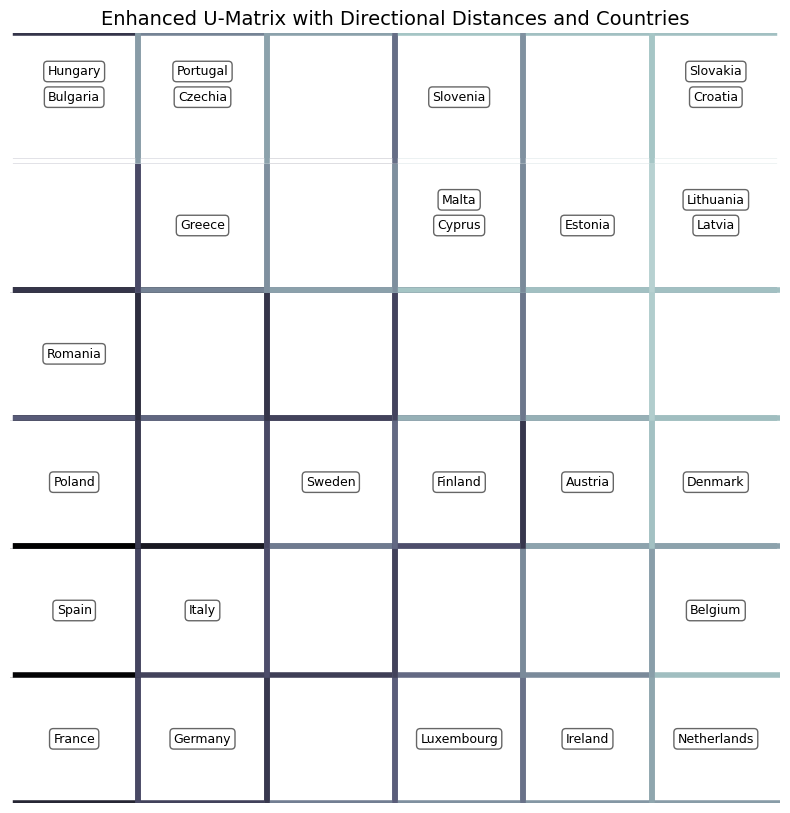

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from collections import defaultdict
from numpy.linalg import norm

# Compute directional distances for each neuron: [top, right, bottom, left]
weights = som.get_weights()
umatrix = np.zeros((som_shape[0], som_shape[1], 4))  # shape: (rows, cols, 4 directions)
max_dist = 0

for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        w = weights[i, j]
        if i > 0:  # top
            d = norm(w - weights[i - 1, j])
            umatrix[i, j, 0] = d
            max_dist = max(max_dist, d)
        if j < som_shape[1] - 1:  # right
            d = norm(w - weights[i, j + 1])
            umatrix[i, j, 1] = d
            max_dist = max(max_dist, d)
        if i < som_shape[0] - 1:  # bottom
            d = norm(w - weights[i + 1, j])
            umatrix[i, j, 2] = d
            max_dist = max(max_dist, d)
        if j > 0:  # left
            d = norm(w - weights[i, j - 1])
            umatrix[i, j, 3] = d
            max_dist = max(max_dist, d)

# Group countries by their BMU positions
bmu_positions = defaultdict(list)
for i, x in enumerate(data_scaled):
    bmu = som.winner(x)
    bmu_positions[bmu].append(country_names[i])

# Plot the enhanced U-matrix
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        x, y = j, i  # Grid coordinates

        # Normalize directional distances
        #top, right, bottom, left = umatrix[i, j] / max_dist
        top = np.sqrt(umatrix[i, j, 0] / max_dist)
        right = np.sqrt(umatrix[i, j, 1] / max_dist)
        bottom = np.sqrt(umatrix[i, j, 2] / max_dist)
        left = np.sqrt(umatrix[i, j, 3] / max_dist)

        # Base square
        ax.add_patch(Rectangle((x, y), 1, 1, facecolor='white', edgecolor='gray'))

        # Directional edge colors (top, right, bottom, left)
        ax.plot([x, x + 1], [y + 1, y + 1], color=cm.bone_r(top), linewidth=4)     # top
        ax.plot([x + 1, x + 1], [y, y + 1], color=cm.bone_r(right), linewidth=4)   # right
        ax.plot([x, x + 1], [y, y], color=cm.bone_r(bottom), linewidth=4)          # bottom
        ax.plot([x, x], [y, y + 1], color=cm.bone_r(left), linewidth=4)            # left

# Plot country names stacked vertically
for (x, y), names in bmu_positions.items():
    for i, name in enumerate(names):
        ax.text(x + 0.5, y + 0.5 + i * 0.2, name,
                fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

# Final layout settings
ax.set_xlim(0, som_shape[1])
ax.set_ylim(0, som_shape[0])
ax.set_ylim(som_shape[0], 0)
ax.set_aspect('equal')
plt.gca().invert_yaxis()  # Keep origin in top-left like in previous plots
plt.axis('off')
plt.title("Enhanced U-Matrix with Directional Distances and Countries", fontsize=14)
plt.show()


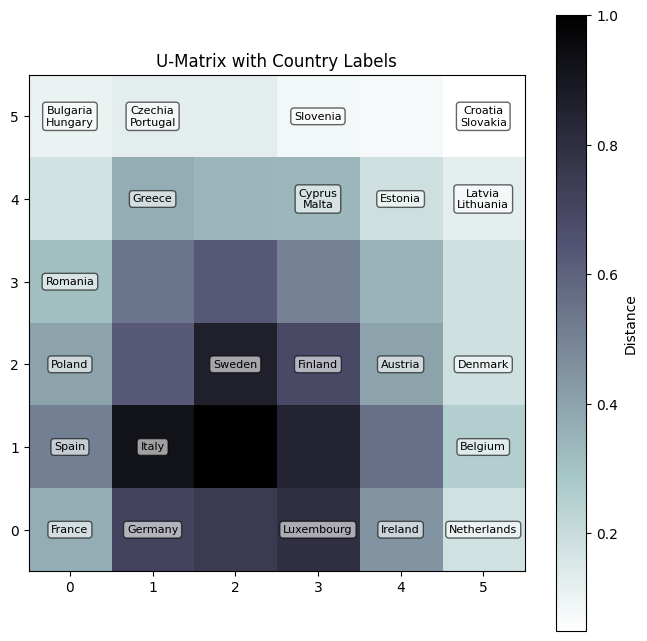

In [119]:
plot_U_matrix(som, bmu_positions)

## U-matrix 3D Surface

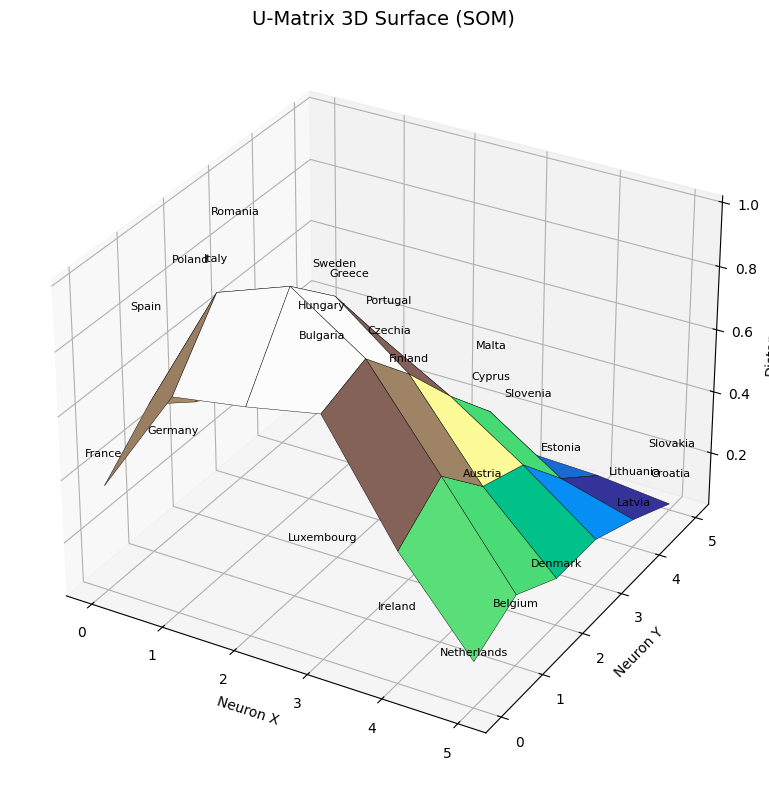

In [120]:
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_U_matrix_3D(som, data_scaled, country_names):
    u_matrix = som.distance_map().T  # Transposed for correct orientation
    x_len, y_len = u_matrix.shape
    X, Y = np.meshgrid(np.arange(x_len), np.arange(y_len))

    # Get BMUs for labeling
    bmu_positions = defaultdict(list)
    for i, x in enumerate(data_scaled):
        bmu = som.winner(x)
        bmu_positions[bmu].append(country_names[i])

    # 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, u_matrix, cmap='terrain', edgecolor='k', linewidth=0.3, antialiased=True)

    # Plot labels (elevated slightly above the surface)
    for (x, y), names in bmu_positions.items():
        for i, name in enumerate(names):
            z = u_matrix[x, y] + 0.1 + i * 0.1
            ax.text(x, y, z, name, fontsize=8, ha='center', va='center')

    ax.set_title('U-Matrix 3D Surface (SOM)', fontsize=14)
    ax.set_xlabel("Neuron X")
    ax.set_ylabel("Neuron Y")
    ax.set_zlabel("Distance")
    plt.tight_layout()
    plt.show()
plot_U_matrix_3D(som, data_scaled, country_names)

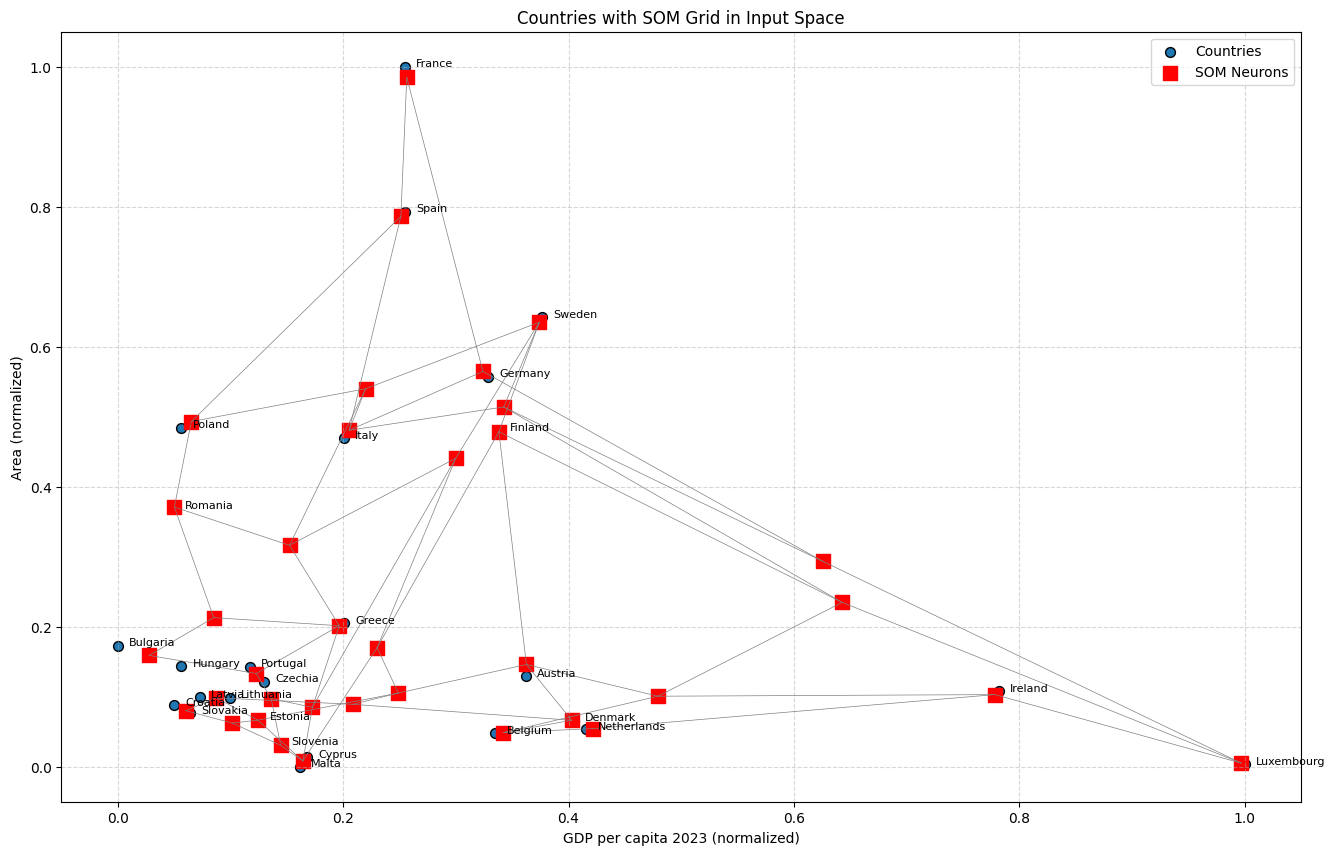

In [121]:
index_0 = 2
index_1 = 0
plt.figure(figsize=(16, 10))

# Plot data points
plt.scatter(data_scaled[:, index_0], data_scaled[:, index_1], s=50, edgecolor='k', label='Countries')

# Add country names
for i, name in enumerate(country_names):
    plt.text(data_scaled[i, index_0] + 0.01, data_scaled[i, index_1], name, fontsize=8)

# Plot SOM neuron weights (i.e., grid in input space)
weights = som.get_weights().reshape(-1, data_scaled.shape[1])  # (num_neurons, 2)
plt.scatter(weights[:, index_0], weights[:, index_1], marker='s', s=100, c='red', label='SOM Neurons')

# Optionally: connect neurons in a grid (lines)
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i, j + 1]
        plt.plot([w1[index_0], w2[index_0]], [w1[index_1], w2[index_1]], 'gray', linewidth=0.5)
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i + 1, j]
        plt.plot([w1[index_0], w2[index_0]], [w1[index_1], w2[index_1]], 'gray', linewidth=0.5)

plt.title("Countries with SOM Grid in Input Space")
plt.xlabel(labels[index_0])
plt.ylabel(labels[index_1])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


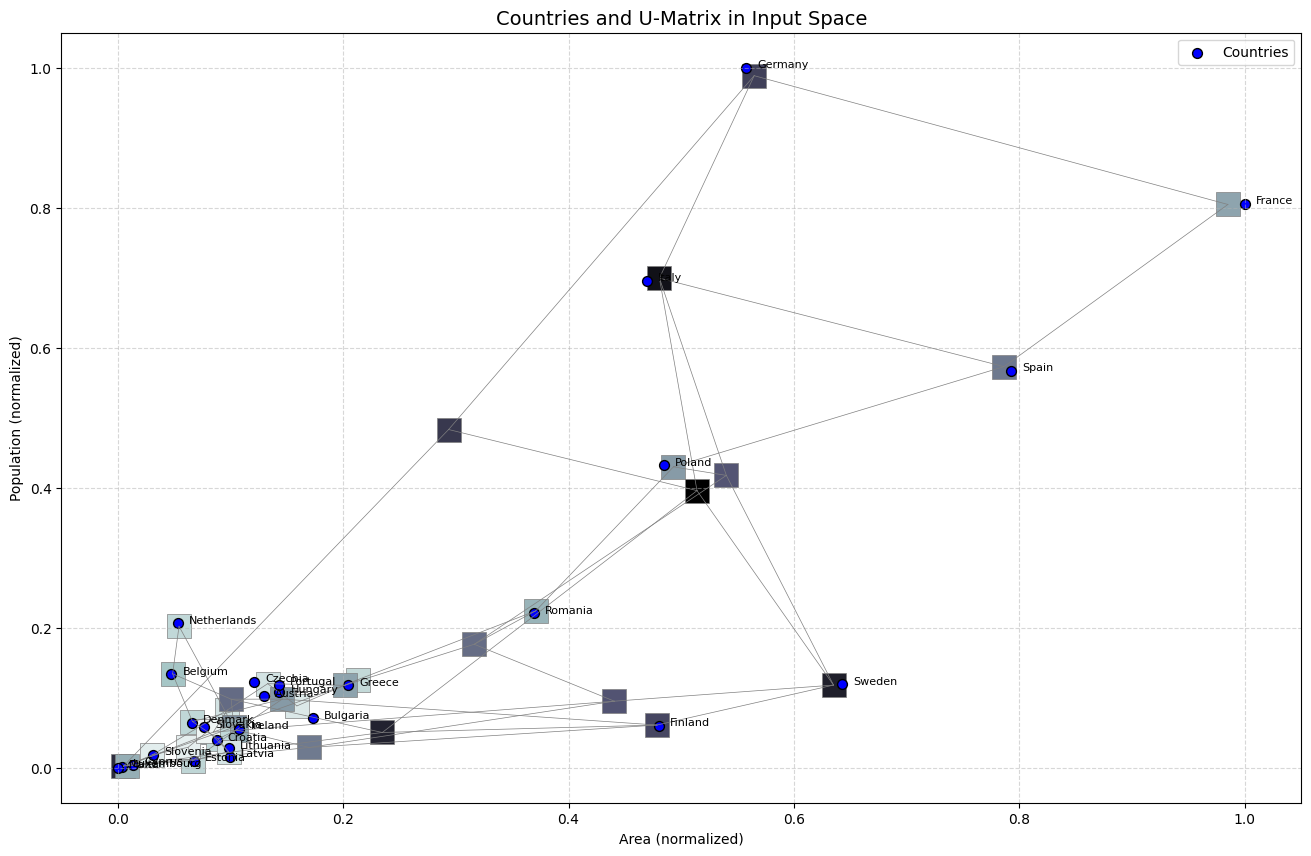

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Prepare U-matrix values as list of distances for each neuron
u_matrix = som.distance_map()

# Get weights and flatten them
weights = som.get_weights()
w_flat = weights.reshape(-1, weights.shape[2])  # shape (n_neurons, 2)

# Create figure
plt.figure(figsize=(16, 10))

# Plot U-matrix as background: place each neuron's U-value at its weight position
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        w = weights[i, j]
        u = u_matrix[i, j]
        plt.scatter(w[0], w[1], color=cm.bone_r(u), s=300, marker='s', edgecolor='gray', linewidth=0.5)

# Connect neighboring neurons with gray lines (grid)
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        w1 = weights[i, j]
        w2 = weights[i, j + 1]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        w1 = weights[i, j]
        w2 = weights[i + 1, j]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)

# Plot original data points (countries)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], s=50, edgecolor='black', facecolor='blue', label='Countries')
for i, name in enumerate(country_names):
    plt.text(data_scaled[i, 0] + 0.01, data_scaled[i, 1], name, fontsize=8)

# Final touches
plt.title("Countries and U-Matrix in Input Space", fontsize=14)
plt.xlabel("Area (normalized)")
plt.ylabel("Population (normalized)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


## Sammon projection

Iter 1: stress = 1.930051
Iter 2: stress = 1.861106
Iter 3: stress = 1.797638
Iter 4: stress = 1.740167
Iter 5: stress = 1.688239
Iter 6: stress = 1.641318
Iter 7: stress = 1.598877
Iter 8: stress = 1.560425
Iter 9: stress = 1.525513
Iter 10: stress = 1.493730
Iter 11: stress = 1.464707
Iter 12: stress = 1.438113
Iter 13: stress = 1.413648
Iter 14: stress = 1.391048
Iter 15: stress = 1.370073
Iter 16: stress = 1.350513
Iter 17: stress = 1.332179
Iter 18: stress = 1.314902
Iter 19: stress = 1.298533
Iter 20: stress = 1.282937
Iter 21: stress = 1.267997
Iter 22: stress = 1.253604
Iter 23: stress = 1.239663
Iter 24: stress = 1.226091
Iter 25: stress = 1.212814
Iter 26: stress = 1.199774
Iter 27: stress = 1.186924
Iter 28: stress = 1.174230
Iter 29: stress = 1.161666
Iter 30: stress = 1.149216
Iter 31: stress = 1.136870
Iter 32: stress = 1.124623
Iter 33: stress = 1.112472
Iter 34: stress = 1.100418
Iter 35: stress = 1.088461
Iter 36: stress = 1.076604
Iter 37: stress = 1.064850
Iter 38: s

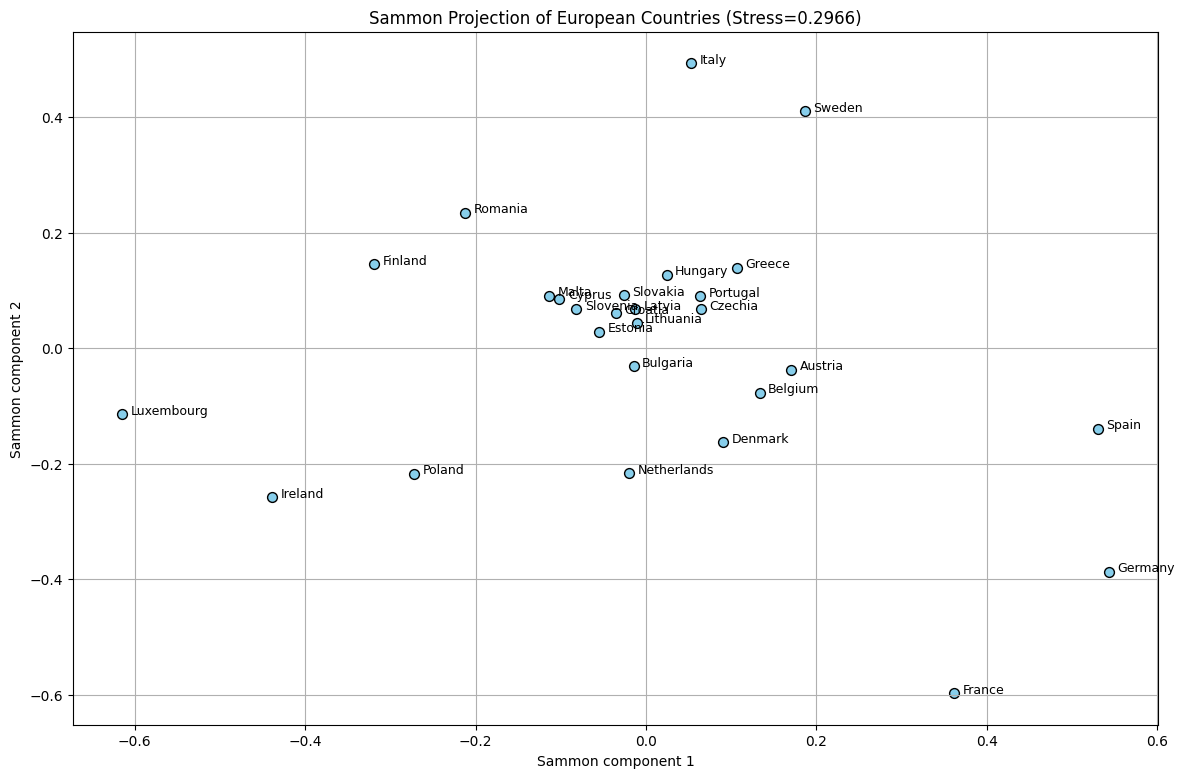

In [123]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def sammon(X, n_components=2, max_iter=500, tol=1e-9, alpha=0.3, verbose=False):
    """
    Perform Sammon mapping on dataset X to reduce to n_components dimensions.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
    - n_components: int, target dimensionality (usually 2)
    - max_iter: int, number of iterations
    - tol: float, convergence tolerance
    - alpha: float, learning rate
    - verbose: bool, print error per iteration

    Returns:
    - Y: mapped data in n_components dimensions
    - E: final Sammon stress (error)
    """

    X = np.array(X)
    N = X.shape[0]

    # Compute original distance matrix
    D = squareform(pdist(X))
    D[D == 0] = 1e-10  # Avoid division by zero
    scale = D.sum()

    # Initialize Y with small random values
    Y = np.random.normal(0, 1e-4, (N, n_components))
    delta = np.zeros_like(Y)

    for it in range(max_iter):
        Y_old = Y.copy()
        D_Y = squareform(pdist(Y))
        D_Y[D_Y == 0] = 1e-10

        delta_Y = D - D_Y
        ratio = delta_Y / D
        stress = ((ratio**2).sum()) / scale

        if verbose:
            print(f"Iter {it+1}: stress = {stress:.6f}")

        # Gradient computation
        for i in range(N):
            for j in range(N):
                if i != j:
                    diff = Y[i] - Y[j]
                    grad = -2 * (D[i, j] - D_Y[i, j]) / (D[i, j] * D_Y[i, j]) * diff
                    delta[i] += grad

        Y -= alpha * delta
        delta[:] = 0  # reset for next iteration

        # Check for convergence
        if np.linalg.norm(Y - Y_old) < tol:
            break

    return Y, stress

# Apply Sammon projection:
Y_sammon, stress = sammon(data_scaled, n_components=2, max_iter=300, alpha=0.0001, verbose=True)

# Vizualizace výsledku
plt.figure(figsize=(14, 9))
plt.scatter(Y_sammon[:, 0], Y_sammon[:, 1], c='skyblue', s=50, edgecolor='k')

for i, name in enumerate(country_names):
    plt.text(Y_sammon[i, 0] + 0.01, Y_sammon[i, 1], name, fontsize=9)

plt.title(f"Sammon Projection of European Countries (Stress={stress:.4f})")
plt.xlabel("Sammon component 1")
plt.ylabel("Sammon component 2")
plt.grid(True)
plt.show()


Iter 1: stress = 2.017302
Iter 2: stress = 1.952653
Iter 3: stress = 1.982022
Iter 4: stress = 2.058423
Iter 5: stress = 2.153227
Iter 6: stress = 2.251591
Iter 7: stress = 2.346382
Iter 8: stress = 2.434728
Iter 9: stress = 2.514507
Iter 10: stress = 2.586594
Iter 11: stress = 2.652587
Iter 12: stress = 2.713445
Iter 13: stress = 2.769922
Iter 14: stress = 2.822527
Iter 15: stress = 2.871541
Iter 16: stress = 2.916677
Iter 17: stress = 2.957092
Iter 18: stress = 2.994647
Iter 19: stress = 3.029553
Iter 20: stress = 3.061690
Iter 21: stress = 3.091011
Iter 22: stress = 3.117479
Iter 23: stress = 3.140981
Iter 24: stress = 3.161311
Iter 25: stress = 3.178393
Iter 26: stress = 3.192440
Iter 27: stress = 3.203805
Iter 28: stress = 3.212815
Iter 29: stress = 3.219724
Iter 30: stress = 3.224724
Iter 31: stress = 3.227993
Iter 32: stress = 3.229634
Iter 33: stress = 3.229706
Iter 34: stress = 3.228331
Iter 35: stress = 3.225761
Iter 36: stress = 3.222253
Iter 37: stress = 3.217972
Iter 38: s

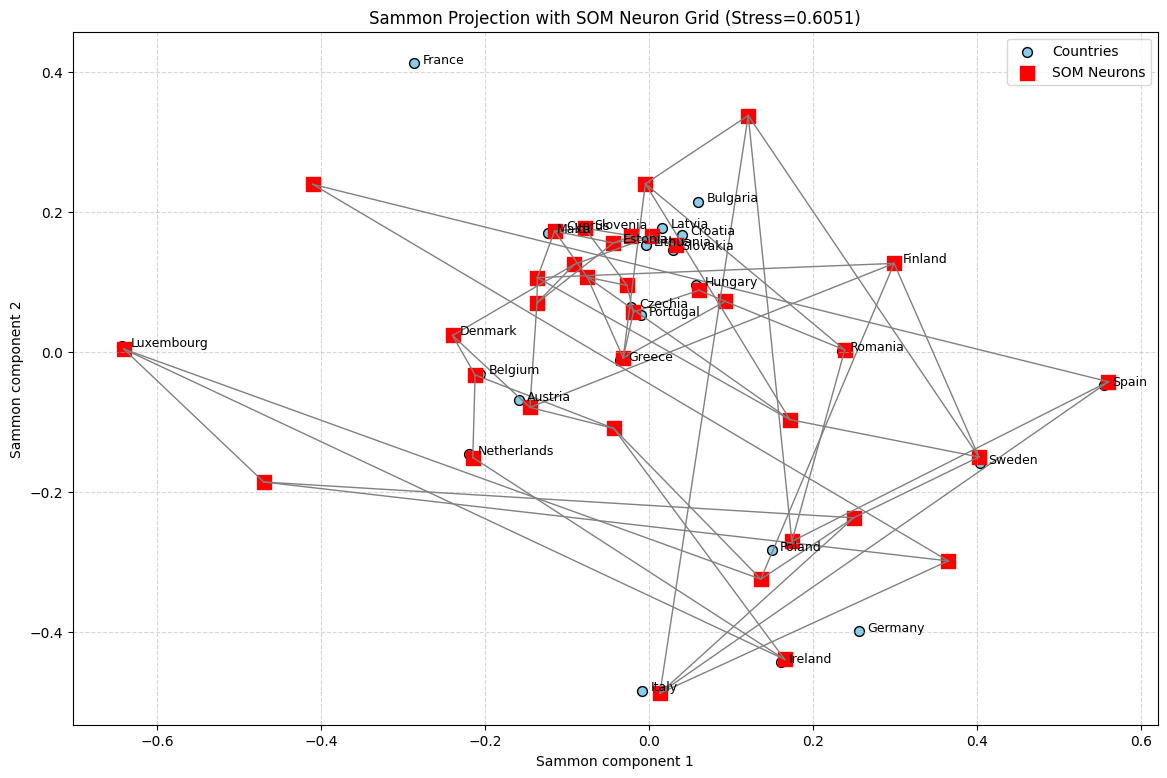

In [124]:
# 1. Flatten SOM weights to (num_neurons, input_dim)
weights = som.get_weights().reshape(-1, data_scaled.shape[1])  # e.g. (25, 3) if 5x5 SOM

# 2. Combine data and neuron weights for joint Sammon projection
combined = np.vstack([data_scaled, weights])

# 3. Apply Sammon projection
Y_sammon, stress = sammon(combined, n_components=2, max_iter=300, alpha=0.00005, verbose=True)

# 4. Separate back projected data and weights
Y_data = Y_sammon[:len(data_scaled)]
Y_weights = Y_sammon[len(data_scaled):].reshape(som_shape[0], som_shape[1], -1)

# 5. Plot Sammon projection with neuron grid
plt.figure(figsize=(14, 9))

# Plot countries
plt.scatter(Y_data[:, 0], Y_data[:, 1], c='skyblue', s=50, edgecolor='k', label='Countries')
for i, name in enumerate(country_names):
    plt.text(Y_data[i, 0] + 0.01, Y_data[i, 1], name, fontsize=9)

# Plot SOM neurons
plt.scatter(Y_weights[:, :, 0], Y_weights[:, :, 1], c='red', s=100, marker='s', label='SOM Neurons')

# Draw horizontal connections
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        p1 = Y_weights[i, j]
        p2 = Y_weights[i, j + 1]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', linewidth=1)

# Draw vertical connections
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        p1 = Y_weights[i, j]
        p2 = Y_weights[i + 1, j]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', linewidth=1)

# Final plot settings
plt.title(f"Sammon Projection with SOM Neuron Grid (Stress={stress:.4f})")
plt.xlabel("Sammon component 1")
plt.ylabel("Sammon component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
